In [1]:
from pathlib import Path
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import struct
import skimage.transform
import tensorflow as tf
import datetime
import numpy as np


# Dependency imports
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from tensorflow.keras.models import Sequential

from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

# Notebook Extentions
%load_ext tensorboard

In [2]:
print(np.__version__)

1.19.2


# cuDNN Model

## cuDNN Model Prep

In [3]:
X_train = np.load('data/japanese_X_train.npz')['arr_0']
X_val = np.load('data/japanese_X_validation.npz')['arr_0']
y_train = np.load('data/japanese_y_train.npz')['arr_0']
y_val = np.load('data/japanese_y_validation.npz')['arr_0']

In [4]:
# Image dimensions
img_row, img_col = 64, 64

# Classes
japanese_class = 3

In [6]:
# Default shape for cuDNN is 'channels_last', this makes sure everything is in the right order

if K.image_data_format() == 'channels_first':
    japanese_X_train = X_train.reshape(X_train.shape[0], 1, img_row, img_col)
    japanese_X_val = X_val.reshape(X_val.shape[0], 1, img_row, img_col)
    japanese_shape = (1, img_row, img_col) 
else:
    japanese_X_train = X_train.reshape(X_train.shape[0], img_row, img_col, 1)
    japanese_X_val = X_val.reshape(X_val.shape[0], img_row, img_col, 1)
    japanese_shape = (img_row, img_col, 1)

In [20]:
X_train.shape

(138204, 64, 64)

In [41]:
X_val.shape

(34552, 64, 64)

In [22]:
X_train[0].shape

(64, 64)

In [39]:
cudnn_model = models.Sequential()

cudnn_model.add(LSTM(128, input_shape = (X_train.shape[1:]), return_sequences = True))
cudnn_model.add(Dropout(0.2))

cudnn_model.add(LSTM(128))
cudnn_model.add(Dropout(0.2))

cudnn_model.add(Flatten())
cudnn_model.add(Dense(256, activation = 'relu'))
cudnn_model.add(Dropout(0.2))
cudnn_model.add(Dense(japanese_class, activation = 'softmax'))

In [40]:
cudnn_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 64, 128)           98816     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)             

In [30]:
# Callbacks
japanese_es = EarlyStopping(patience = 3, verbose = 1, restore_best_weights = True)
japanese_lr = ReduceLROnPlateau(factor = 0.5, patience = 2, verbose = 1)

# Tensorboard Callback
japanese_log_dir = 'logs/cuDNN/' + datetime.datetime.now().strftime('Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = japanese_log_dir, histogram_freq = 1)

### Adding Variation with ImageDataGenerator
- Tensorflow's ImageDataGenerator can augment images to create new vesions of the data, essentially artificially inserting variation into the data
- Images can be rotated, zoomed, and flipped
- This variation is used to avoid overfitting on the training set
- Following augmentation is for a 2D cuDNN

### cuDNN Model Run

In [42]:
opt = tf.keras.optimizers.Adam(lr = 1e-3, decay = 1e-5)

cudnn_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

cudnn_results = cudnn_model.fit(X_train, y_train, batch_size = 32,\
          epochs = 30, callbacks = (japanese_es, japanese_lr, tensorboard_callback), validation_data = (X_val, y_val))

Epoch 1/30
   1/4319 [..............................] - ETA: 0s - loss: 1.0981 - accuracy: 0.3125WARNING:tensorflow:From C:\Users\Administrator\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4319/4319 [==============================] - 468s 108ms/step - loss: 0.1166 - accuracy: 0.9588 - val_loss: 0.0725 - val_accuracy: 0.9721
Epoch 2/30
4319/4319 [==============================] - 465s 108ms/step - loss: 0.0632 - accuracy: 0.9779 - val_loss: 0.0598 - val_accuracy: 0.9795
Epoch 3/30
4319/4319 [==============================] - 465s 108ms/step - loss: 0.0486 - accuracy: 0.9826 - val_loss: 0.0360 - val_accuracy: 0.9872
Epoch 4/30
4319/4319 [==============================] - 464s 107ms/step - loss: 0.0365 - accuracy: 0.9873 - val_loss: 0.0316 - val_accuracy: 0.9891
Epoch 5/30
4319/4319

In [43]:
cudnn_model.save('models/cudnn_model.h5')

### cuDNN Model Evaluation

In [44]:
cudnn_history = cudnn_results.history
cudnn_training_loss = cudnn_history['loss']
cudnn_val_loss = cudnn_history['val_loss']
cudnn_training_accuracy = cudnn_history['accuracy']
cudnn_val_accuracy = cudnn_history['val_accuracy']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

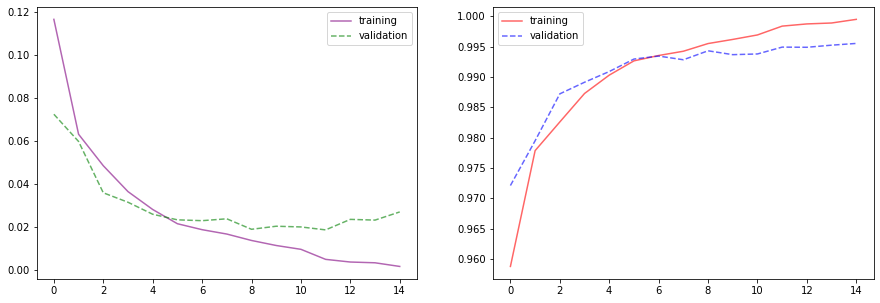

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x = list(range(len(cudnn_training_loss))),
             y = cudnn_training_loss, color = 'purple', alpha = 0.6, label='training', ax = ax1)
sns.lineplot(x = list(range(len(cudnn_val_loss))),
             y = cudnn_val_loss, color = 'green', alpha = 0.6, linestyle = 'dashed', label = 'validation', ax = ax1)
sns.lineplot(x = list(range(len(cudnn_training_loss))),
             y = cudnn_training_accuracy, color='r', alpha = 0.6, label='training',ax = ax2)
sns.lineplot(x = list(range(len(cudnn_val_loss))),
             y = cudnn_val_accuracy, color = 'b', alpha = 0.6, linestyle = 'dashed', label = 'validation',ax = ax2)
# plt.savefig('img/cudnn_loss_acc')
ax1.legend();